In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sns
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import mdtraj as md
import pickle
from tqdm import tqdm
import itertools
from deeptime.decomposition import TICA

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [3]:
# Importing Files Like Input Data, Label Data, Tica Object, and Employed Train Test Split
input_data  = np.load("tic_projection_concatenate.pkl.npy")  # tic transform data
label_data = np.load("five_trajectory_all_atom-02-07-24.pkl.npy")  # label data for each frame and each heavy atom
i_train, i_temp, j_train, j_temp = train_test_split(input_data, label_data, test_size=0.40, shuffle=True, random_state = 42)  # dividing into train and temp data
x_val, x_test, y_val, y_test = train_test_split(i_temp, j_temp, test_size=0.50, shuffle=True, random_state= 42)  # dividing into val and test data'''

In [4]:
# Convert data to torch tensors and move to device
data_train_tensor = torch.tensor(i_train, dtype=torch.float32).to(device)
label_train_tensor = torch.tensor(j_train, dtype=torch.float32).to(device)
data_val_tensor = torch.tensor(x_val, dtype=torch.float32).to(device)
label_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
data_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
label_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [5]:
# Load the tica object
with open('tica_object.pkl', 'rb') as file:
    tica_object = pickle.load(file)

In [6]:
# Save backup data
np.save("backup_train_test/i_train.pkl", i_train, allow_pickle=True, fix_imports=True)
np.save("backup_train_test/j_train.pkl", j_train, allow_pickle=True, fix_imports=True)
np.save("backup_train_test/x_val.pkl", x_val, allow_pickle=True, fix_imports=True)
np.save("backup_train_test/y_val.pkl", y_val, allow_pickle=True, fix_imports=True)
np.save("backup_train_test/x_test.pkl", x_test, allow_pickle=True, fix_imports=True)
np.save("backup_train_test/y_test.pkl", y_test, allow_pickle=True, fix_imports=True)

In [7]:
# Print the shape of the data
print("Input data shape:", input_data.shape)
print("Label data shape:", label_data.shape)
print("Input data training set:", i_train.shape)
print("Input data test set", x_test.shape)
print("Validation input:", x_val.shape)
print("Test input:", x_test.shape)
print("Validation output:", y_val.shape)
print("Test output:", y_test.shape)
print('Data train tensor:', data_train_tensor.shape)
print('Label train tensor:', label_train_tensor.shape)
print('Data test tensor:', data_test_tensor.shape)
print('Label test tensor:', label_test_tensor.shape)

Input data shape: (25005, 280)
Label data shape: (25005, 94, 3)
Input data training set: (15003, 280)
Input data test set (5001, 280)
Validation input: (5001, 280)
Test input: (5001, 280)
Validation output: (5001, 94, 3)
Test output: (5001, 94, 3)
Data train tensor: torch.Size([15003, 280])
Label train tensor: torch.Size([15003, 94, 3])
Data test tensor: torch.Size([5001, 280])
Label test tensor: torch.Size([5001, 94, 3])


In [8]:
# Creating Hyperparameters for the Neural Network
input_size = 280      # the size of the input same as number of tics
hidden_1 = 280        # hidden layer 1
hidden_2 = 281        # hidden layer 2
hidden_3 = 281        # hidden layer 3
hidden_4 = 282        # hidden layer 4
hidden_5 = 282        # hidden layer 5
output_size = 282     # output layer same as 94 * 3 (94 atoms and 3 trajectory)
# Dropouts
dropout_1 = 0.50      # dropout-1 to prevent overfitting
dropout_2 = 0.25      # dropout-2 to prevent overfitting
dropout_3 = 0.25      # dropout-3 to prevent overfitting
dropout_4 = 0.25      # dropout-4 to prevent overfitting
# Hyperparameters
batch = 128               # batch size
learning_rate = 0.001    # learning rate
epochs = 15               # number of epochs

In [9]:
# Neural Network Class (MLP)
class Fully_connected_neuron(nn.Module):
    def __init__(self):
        super(Fully_connected_neuron, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.dropout1 = nn.Dropout(dropout_1)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.dropout2 = nn.Dropout(dropout_2)
        self.act3 = nn.ReLU()
        
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.dropout3 = nn.Dropout(dropout_3)
        self.act4 = nn.ReLU()
        
        self.fc5 = nn.Linear(hidden_4, hidden_5)
        self.dropout4 = nn.Dropout(dropout_4)
        self.act5 = nn.Sigmoid()

        self.fc6 = nn.Linear(hidden_5, output_size)

    
    def forward(self, x1):
        x2 = torch.nn.functional.linear(x1, self.fc1.weight.clone(), self.fc1.bias)
        x3 = self.act1(x2)
        
        x4 = torch.nn.functional.linear(x3, self.fc2.weight.clone(), self.fc2.bias)
        x5 = self.dropout1(x4)
        x6 = self.act2(x5)
        
        x7 = torch.nn.functional.linear(x6, self.fc3.weight.clone(), self.fc3.bias)
        x8 = self.dropout2(x7)
        x9 = self.act3(x8)
        
        x10 = torch.nn.functional.linear(x9, self.fc4.weight.clone(), self.fc4.bias)
        x11 = self.dropout3(x10)
        x12 = self.act4(x11)

        x13 = torch.nn.functional.linear(x12, self.fc5.weight.clone(), self.fc5.bias)
        x14 = self.dropout4(x13)
        x15 = self.act5(x14)

        x16 = torch.nn.functional.linear(x15, self.fc6.weight.clone(), self.fc6.bias)

        x17 = x16.view(-1, 94, 3)
        return x17

In [10]:
# Initialize the model and move to device
fcn = Fully_connected_neuron().to(device)
print(fcn)

Fully_connected_neuron(
  (fc1): Linear(in_features=280, out_features=280, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=280, out_features=281, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (act2): ReLU()
  (fc3): Linear(in_features=281, out_features=281, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (act3): ReLU()
  (fc4): Linear(in_features=281, out_features=282, bias=True)
  (dropout3): Dropout(p=0.25, inplace=False)
  (act4): ReLU()
  (fc5): Linear(in_features=282, out_features=282, bias=True)
  (dropout4): Dropout(p=0.25, inplace=False)
  (act5): Sigmoid()
  (fc6): Linear(in_features=282, out_features=282, bias=True)
)


In [11]:
state_dict = torch.load('model_weights_epoch_91.pt')
fcn.load_state_dict(state_dict)

<All keys matched successfully>

In [12]:
# Optimizer
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate)

In [13]:
# Function to calculate the Tica of the batch trajectories
def tica_extraction(n):
    act_pdb = md.load_pdb('pentapeptide-impl-solv.pdb')
    topology = act_pdb.topology
    n = n.unsqueeze(0)  # Adds an additional dimension at index 0
    act_pdb.xyz = n.cpu().numpy()  # Convert tensor to numpy array and move to CPU
    traj_top = act_pdb.topology
    heavy_atoms = [atom.index for atom in traj_top.atoms if atom.element.symbol != 'H']
    pairs = list(itertools.product(heavy_atoms, heavy_atoms))
    pair_1 = [j for j in pairs if j[0] != j[1]]
    filter_pair = []
    for i in pair_1:
        if tuple(reversed(i)) not in filter_pair:
            filter_pair.append(i)
    distances = md.compute_distances(act_pdb, filter_pair)
    projection = [tica_object.transform(x) for x in distances]
    pro = torch.tensor(np.array(projection), dtype=torch.float32).to(device)
    return pro

In [14]:
# Custom Loss Class
class Custom_Loss(nn.Module):
    def __init__(self):
        super(Custom_Loss, self).__init__()
    def forward(self, target, predict, target_tica, predict_tica):
        x = torch.mean((predict - target) ** 2)
        y = torch.mean((target_tica - predict_tica) ** 2)
        z = x + (2 * y)
        return z

In [15]:
# Initialize the custom loss
Criteria = Custom_Loss()

In [16]:
# Training Loop with progress bar
'''epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0 
    for i in range(0, 2000, batch):
        train_mini = data_train_tensor[i:i+batch]
        label_mini = label_train_tensor[i:i+batch]
        optimizer.zero_grad()
        net_output = fcn(train_mini)
        batch_loss = 0

        for k in range(train_mini.shape[0]):
            new = net_output[k].detach()
            predicted_tica = tica_extraction(new)
            loss = Criteria(label_mini[k], net_output[k], train_mini[k], predicted_tica).clone()
            loss.backward(retain_graph=True)
            batch_loss += loss.item()
            
        optimizer.step()
        epoch_loss += batch_loss    

    epoch_losses.append(epoch_loss / (2000// batch))
    torch.save(fcn.state_dict(), f'model_weights_epoch_{epoch + 1}.pt')
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss/(2000 // batch):.4f}')
    '''

"epoch_losses = []\n\nfor epoch in range(epochs):\n    epoch_loss = 0 \n    for i in range(0, 2000, batch):\n        train_mini = data_train_tensor[i:i+batch]\n        label_mini = label_train_tensor[i:i+batch]\n        optimizer.zero_grad()\n        net_output = fcn(train_mini)\n        batch_loss = 0\n\n        for k in range(train_mini.shape[0]):\n            new = net_output[k].detach()\n            predicted_tica = tica_extraction(new)\n            loss = Criteria(label_mini[k], net_output[k], train_mini[k], predicted_tica).clone()\n            loss.backward(retain_graph=True)\n            batch_loss += loss.item()\n            \n        optimizer.step()\n        epoch_loss += batch_loss    \n\n    epoch_losses.append(epoch_loss / (2000// batch))\n    torch.save(fcn.state_dict(), f'model_weights_epoch_{epoch + 1}.pt')\n    print(f'Epoch {epoch + 1}, Loss: {epoch_loss/(2000 // batch):.4f}')\n    "

In [17]:
# Training Loop with progress bar
epoch_losses = []

for epoch in range(epochs):
    epoch_loss = 0 
    for i in range(0, data_train_tensor.shape[0], batch):
        train_mini = data_train_tensor[i:i+batch]
        label_mini = label_train_tensor[i:i+batch]
        optimizer.zero_grad()
        net_output = fcn(train_mini)
        batch_loss = 0

        for k in range(train_mini.shape[0]):
            new = net_output[k].detach()
            predicted_tica = tica_extraction(new)
            loss = Criteria(label_mini[k], net_output[k], train_mini[k], predicted_tica).clone()
            loss.backward(retain_graph=True)
            batch_loss += loss.item()
            
        optimizer.step()
        epoch_loss += batch_loss    

    epoch_losses.append(epoch_loss / (data_train_tensor.shape[0]// batch))
    torch.save(fcn.state_dict(), f'model_weights_epoch_{epoch + 92}.pt')
    print(f'Epoch {epoch + 92}, Loss: {epoch_loss/(data_train_tensor.shape[0] // batch):.4f}')

Epoch 92, Loss: 175.5019
Epoch 93, Loss: 80.0337
Epoch 94, Loss: 81.1037
Epoch 95, Loss: 82.3530
Epoch 96, Loss: 83.1930
Epoch 97, Loss: 83.4000
Epoch 98, Loss: 81.0417
Epoch 99, Loss: 82.2825
Epoch 100, Loss: 83.5223
Epoch 101, Loss: 82.1369
Epoch 102, Loss: 82.1018
Epoch 103, Loss: 83.3113
Epoch 104, Loss: 84.4887
Epoch 105, Loss: 82.8056
Epoch 106, Loss: 80.5642


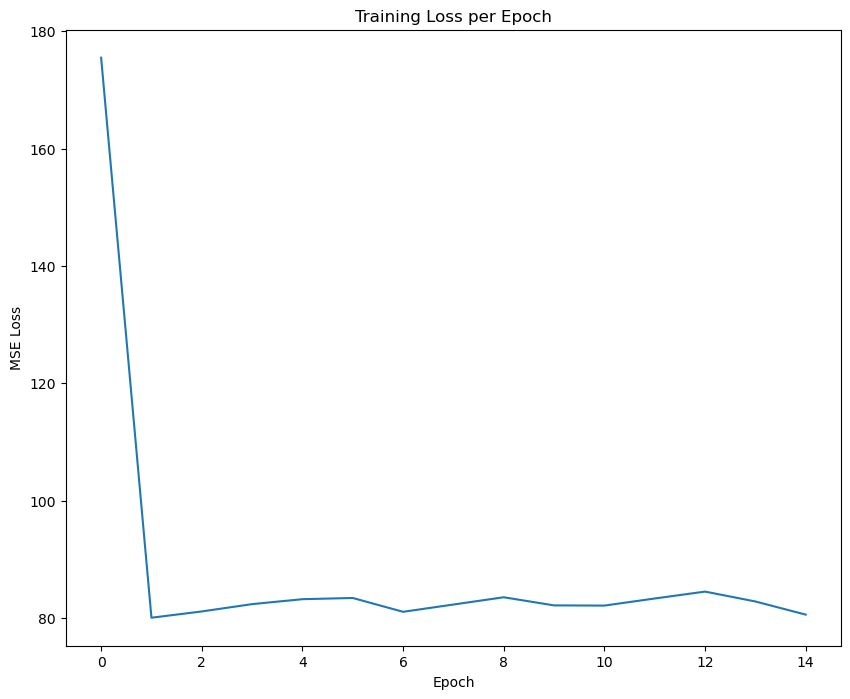

In [18]:
# Plotting the loss per epoch
plt.figure(figsize=(10, 8))
plt.plot(epoch_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss per Epoch')
plt.savefig("backup_train_test/Loss vs Epoch.png", dpi = 400)
plt.show()

In [19]:
# Evaluation mode
fcn.eval()
Validation_predict = fcn(data_val_tensor)

# Saving the predicted validation
np.save("backup_train_test/Validation_predict.pkl", Validation_predict.cpu().detach().numpy(), allow_pickle=True, fix_imports=True)

In [20]:
act = label_val_tensor.cpu().detach().numpy()
pre = Validation_predict.cpu().detach().numpy()

def matrix(act, pre):
    sm_mat = np.zeros((94,94))
    for i in range(94):
        for j in range(94):
            mse = np.mean(np.square(act[i] - pre[j]))
            sm_mat[i, j] = mse
            
            if i != j:
                sm_mat[j, i] = mse

    return sm_mat

empty_list = []
for iter in range(label_val_tensor.shape[0]):
    x = matrix(act[iter], pre[iter])
    empty_list.append(x)
    
Mean_of_all_frame = np.mean(empty_list, axis=0)

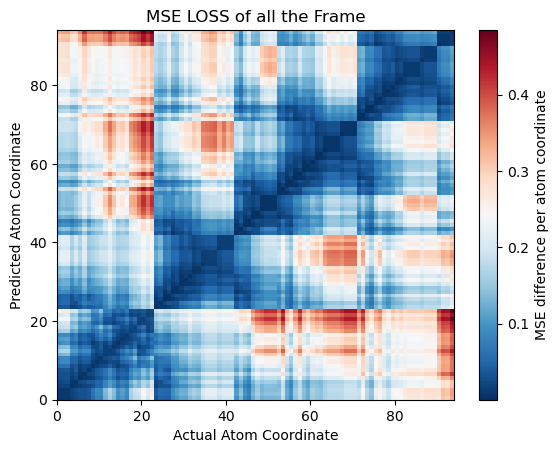

In [21]:
# Plotting the average MSE
cmap = plt.cm.RdBu_r
fig, ax = plt.subplots()
heatmap = ax.pcolormesh(Mean_of_all_frame, cmap = cmap)
fig.colorbar(heatmap, label="MSE difference per atom coordinate")
plt.xlabel("Actual Atom Coordinate")
plt.ylabel("Predicted Atom Coordinate")
plt.title("MSE LOSS of all the Frame")
plt.savefig("backup_train_test/Mse_loss_all_validation_frame.png", dpi = 400)
plt.show()

In [22]:
# Test Predict
Test_predict = fcn(data_test_tensor)

predicted_frame = Test_predict.cpu().detach().numpy()
# Saving the Test prediction
np.save("backup_train_test/Test_predict.pkl",predicted_frame, allow_pickle=True, fix_imports=True)

In [23]:
# Average MSE of all the Frames
actual_frame = label_test_tensor.cpu().detach().numpy()
predicted_frame = Test_predict.cpu().detach().numpy()

def matrix(act, pre):
    mat = np.zeros((94,94))
    for i in range(94):
        for j in range(94):
            mse = np.mean(np.square(act[i] - pre[j]))
            mat[i, j] = mse
            
            if i != j:
                mat[j, i] = mse

    return mat

empty_test_list = []
for iter in range(label_test_tensor.shape[0]):
    x = matrix(actual_frame[iter], predicted_frame[iter])
    empty_test_list.append(x)
    

Mean_of_all_test_frame = np.mean(empty_test_list, axis=0)


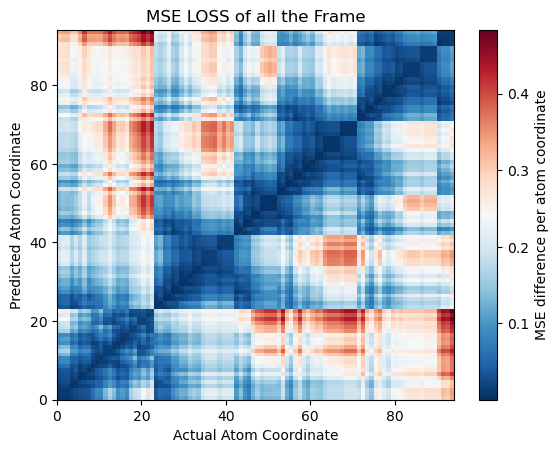

In [24]:
# Plotting the average MSE
cmap = plt.cm.RdBu_r
fig, ax = plt.subplots()
heatmap = ax.pcolormesh(Mean_of_all_test_frame, cmap = cmap)
fig.colorbar(heatmap, label="MSE difference per atom coordinate")
plt.xlabel("Actual Atom Coordinate")
plt.ylabel("Predicted Atom Coordinate")
plt.title("MSE LOSS of all the Frame")
plt.savefig("backup_train_test/Mse_loss_all_test_frame.png", dpi = 400)
plt.show()

In [25]:
# TICA of Predicted Frame
predict_frame = Test_predict.detach()
empty_list = []
for i in range(predicted_frame.shape[0]):
    frame = predict_frame[i]
    project = tica_extraction(frame)
    empty_list.append(project.numpy())

predicted_tica = np.array(empty_list)
predicted_test_tica = np.squeeze(predicted_tica, axis = 1)
np.save("backup_train_test/Predicted_test_tica.pkl", predicted_test_tica, allow_pickle=True, fix_imports=True)

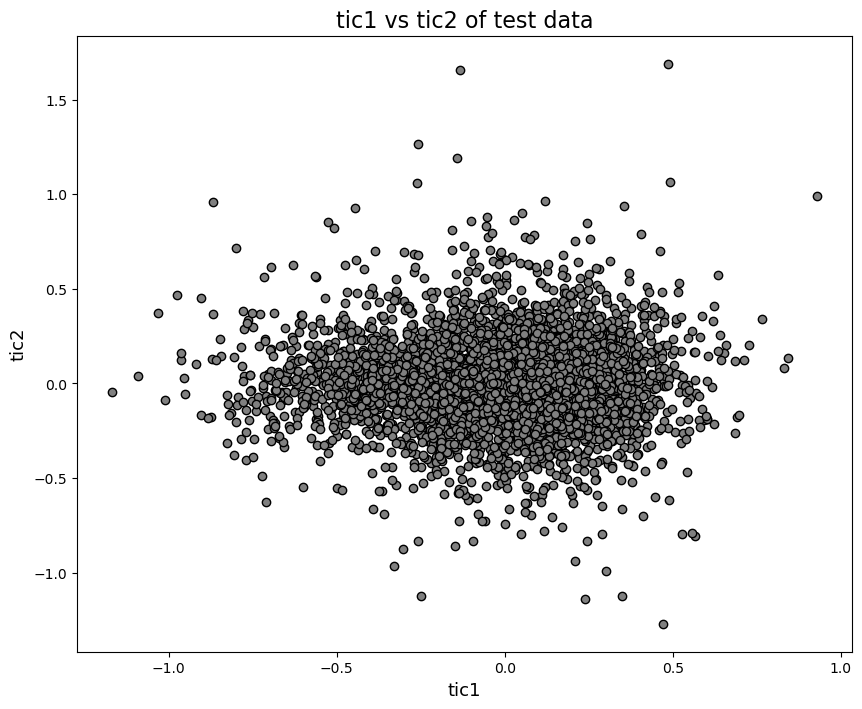

In [26]:
plt.figure(figsize = (10,8))
plt.scatter(x_test[:,0], x_test[:,1], color='gray', edgecolor='black')
plt.xlabel('tic1',fontsize = 13)
plt.ylabel('tic2', fontsize = 13)
plt.title('tic1 vs tic2 of test data', fontsize = 16)
plt.savefig("backup_train_test/tic1 vs tic2 of test data.png", dpi = 400)
plt.show()

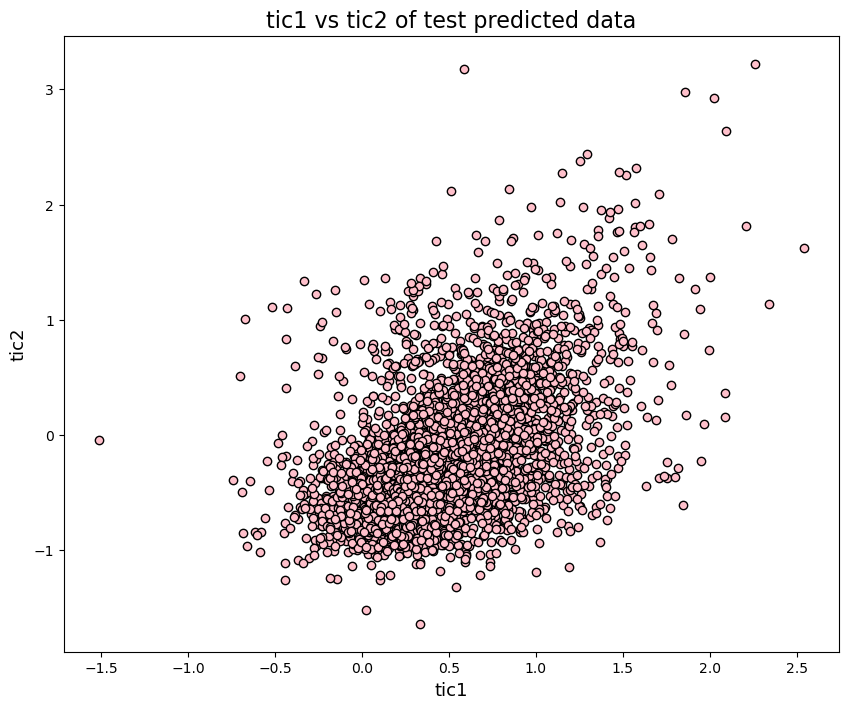

In [27]:
plt.figure(figsize = (10,8))
plt.scatter(predicted_test_tica[:,0], predicted_test_tica[:,1], color='pink', edgecolor='black')
plt.xlabel('tic1',fontsize = 13)
plt.ylabel('tic2', fontsize = 13)
plt.title('tic1 vs tic2 of test predicted data', fontsize = 16)
plt.savefig("backup_train_test/tic1 vs tic2 of test predicted data.png", dpi = 400)
plt.show()

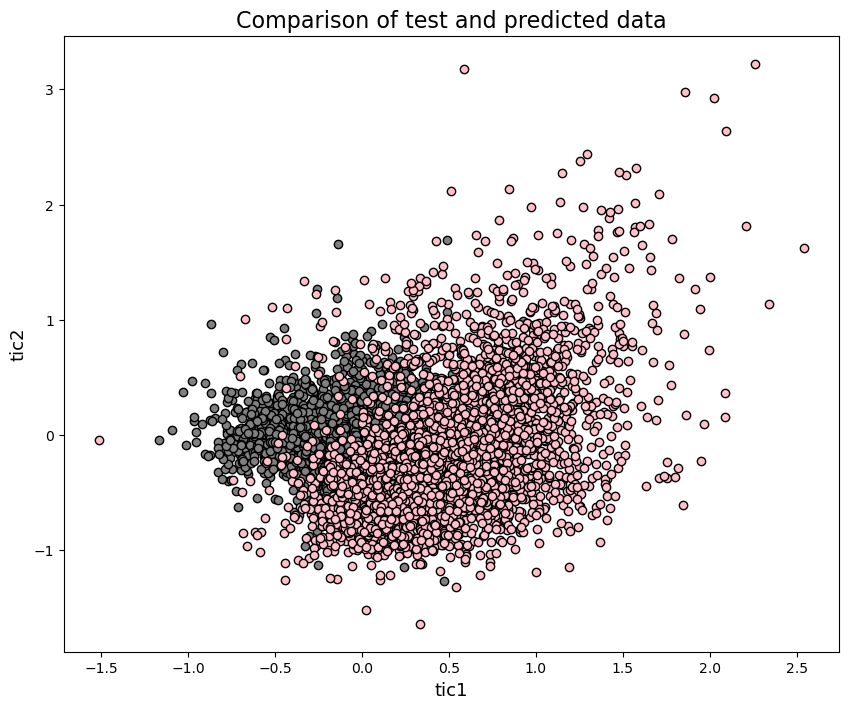

In [28]:
plt.figure(figsize = (10,8))
plt.scatter(x_test[:,0], x_test[:,1], color='gray', edgecolor='black')
plt.scatter(predicted_test_tica[:,0], predicted_test_tica[:,1], color='pink', edgecolor='black')
plt.xlabel('tic1',fontsize = 13)
plt.ylabel('tic2', fontsize = 13)
plt.title('Comparison of test and predicted data', fontsize = 16)
plt.savefig("backup_train_test/tica_dataspread.png", dpi = 400)
plt.show()

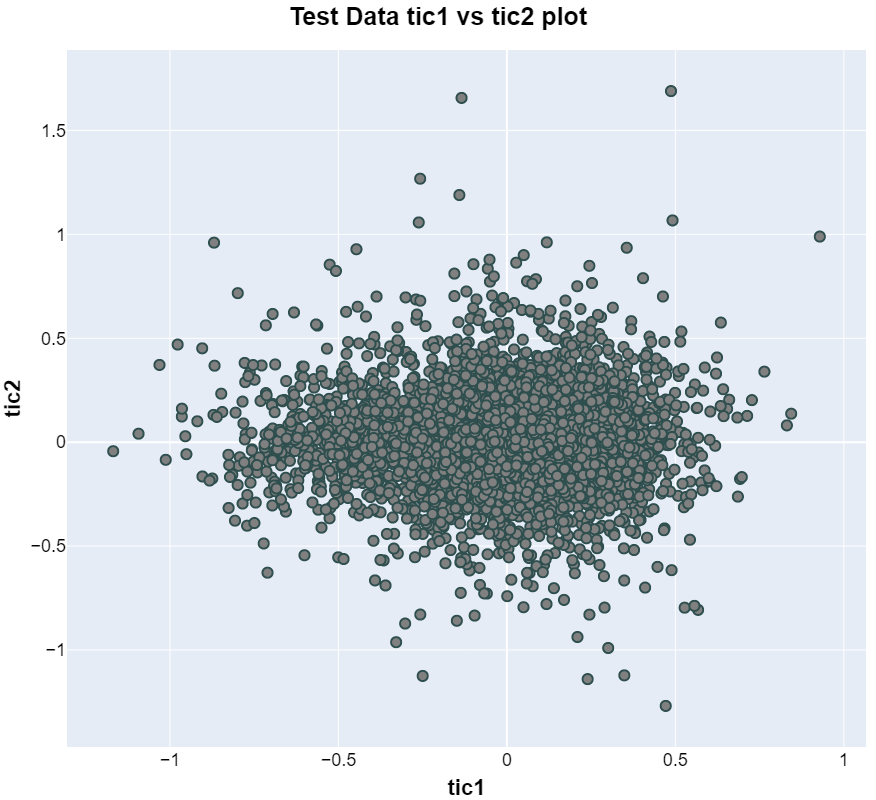

In [29]:
import plotly.express as px
new = [i for i in range(x_test.shape[0])]
fig = px.scatter(x = x_test[:,0],y = x_test[:, 1],height = 800,width=1000,hover_data=[new]).update_layout(xaxis_title = '<b> tic1 </b>',yaxis_title = '<b> tic2 </b>',font = dict(family="Arial,sans-serif",size = 18, color = "black"),title = '<b> Test Data tic1 vs tic2 plot </b>', title_x = 0.5)

                #hover_data=[new]).update_layout(xaxis_title = '<b> tic1 </b>',yaxis_title = '<b> tic2 </b>',font = dict(family="Arial,sans-serif ",size=18, color="black"), title = '<b> Test Data tic1 vs tic2 plot </b>', title_x = 0.5)
fig.update_traces(marker = dict(size = 10,color='grey', line=dict(width=2, color='DarkSlateGrey')),selector=dict(mode='markers'))
fig.update_layout(margin=dict(l=0, r=10, t=50, b=0))

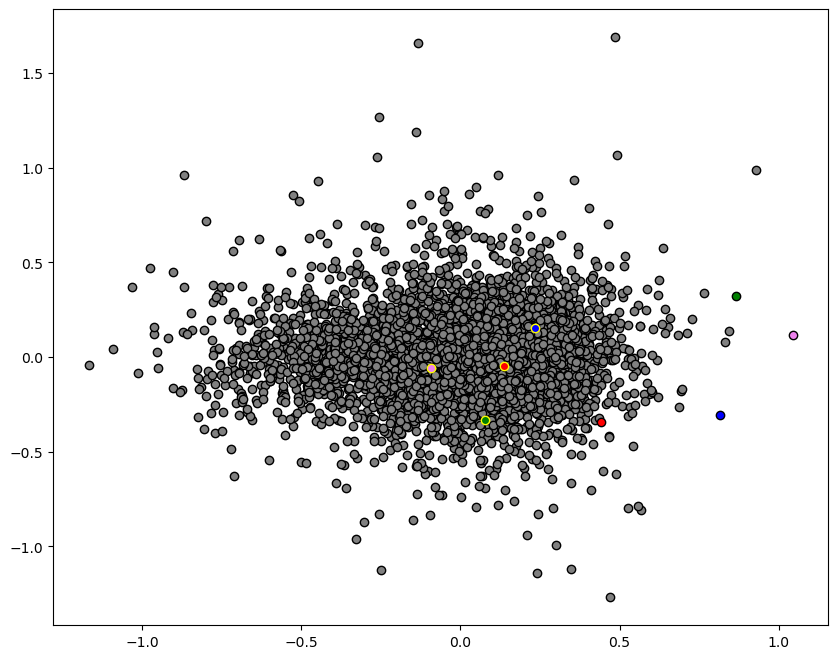

In [30]:
plt.figure(figsize = (10,8))
plt.scatter(x_test[:,0], x_test[:,1], color='gray', edgecolor='black')
plt.scatter(x_test[4339,0], x_test[4339,1], color='violet', edgecolor='yellow') #left
plt.scatter(x_test[2287,0], x_test[2287,1], color='red', edgecolor='yellow') # bottom
plt.scatter(x_test[585,0], x_test[585,1], color='green', edgecolor='yellow') # right
plt.scatter(x_test[5,0], x_test[5,1], color='blue', edgecolor='yellow') # top
plt.scatter(predicted_test_tica[4339,0], predicted_test_tica[4339,1], color='violet', edgecolor='black') # left
plt.scatter(predicted_test_tica[2287,0], predicted_test_tica[2287,1], color='red', edgecolor='black') # bottom
plt.scatter(predicted_test_tica[585,0], predicted_test_tica[585,1], color='green', edgecolor='black') #right
plt.scatter(predicted_test_tica[5,0], predicted_test_tica[5,1], color='blue', edgecolor='black') # top
plt.savefig("backup_train_test/comparison_test_pred.png", dpi = 400)
plt.show()